# Apr ??, 2022 ()

**Motivation**: Make group plots (KABA) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(tr1, tr2, thres=0.1):
    num = len(tr1['proj-top'])
    fig, axes = create_figure(2, num, (13, 4))
    for i in range(num):
        ax = axes[0, i]
        ax.imshow(mwh(tr1['top'] == 0, tr1['top']), cmap='Greys_r')
        ax.imshow(mwh(tr1['proj-top'][i] < thres, tr1['proj-top'][i]))
        ax = axes[1, i]
        ax.imshow(mwh(tr2['top'] == 0, tr2['top']), cmap='Greys_r')
        ax.imshow(mwh(tr2['proj-top'][i] < thres, tr2['proj-top'][i]))
    remove_ticks(axes)
    plt.show()

## Fig dir

In [3]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [4]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 6, 25
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

------------------------------    n_top = 0    ------------------------------

BOLD (corr)   : : :   ovp: 0.8632,  disj: 0.8442

Ca2  (corr)   : : :   ovp: 0.9437,  disj: 0.9394

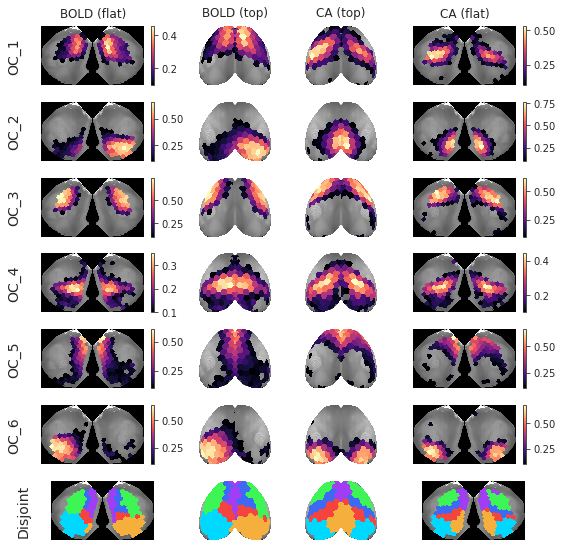

Similarity between OCs (correlation):  Avg = 0.616
OC1: 0.39, OC2: 0.45, OC3: 0.85, OC4: 0.74, OC5: 0.66, OC6: 0.61,

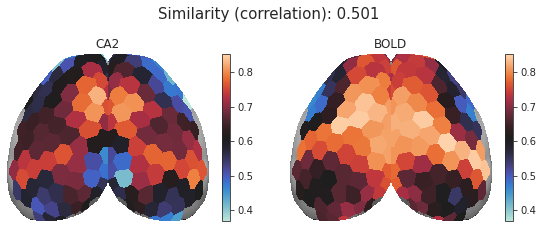

-------------------------------------------------------------------------------

CPU times: user 17min 42s, sys: 1min 9s, total: 18min 52s
Wall time: 7min 3s


In [5]:
%%time

n_top = 0
print('-' * 30, f'   n_top = {n_top}   ', '-' * 30)

gr_ca = Group(**props_ca).fit_group(force=True, n_top=n_top)
gr_bo = Group(**props_bo).fit_group(force=True, n_top=n_top)
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bo.grp_pi,
    XB=gr_ca.grp_pi,
    metric='correlation',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bo.pi = gr_bo.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
proj = gr_ca.project_vec(h, add_disjoint=False)
tr = gr_ca.trim2d(proj)

ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=False,
    min_thres=0.1,
)
score = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
msg = f'Similarity between OCs (correlation):  Avg = {score.mean():0.3f}\n'
for i in range(num_k):
    msg += f'OC{i+1}: {score[i]:0.2f}, '
msg += '\n'
print(msg)

vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
kwargs = {'cmap': 'icefire', 'vmin': vmin, 'vmax': vmax}

fig, axes = create_figure(1, 2, (8, 3))
for ax in axes.flat:
    ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), **kwargs)
plt.colorbar(im, ax=axes[0])
axes[0].set_title('CA2')
im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), **kwargs)
plt.colorbar(im, ax=axes[1])
axes[1].set_title('BOLD')
sim_h = sp_stats.pearsonr(gr_ca.grp_h, gr_bo.grp_h)[0]
fig.suptitle(f'Similarity (correlation): {sim_h:0.3f}', y=1.04, fontsize=15)
remove_ticks(axes)
plt.show()

print('-' * 79)
print('\n\n')

In [37]:
pi = gr_bo.grp_pi.copy()
pi[1][pi[1] < 0.1] = 0
pi[-1][pi[-1] < 0.1] = 0
pi[1] += pi[-1]
pi = pi[:-1]
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

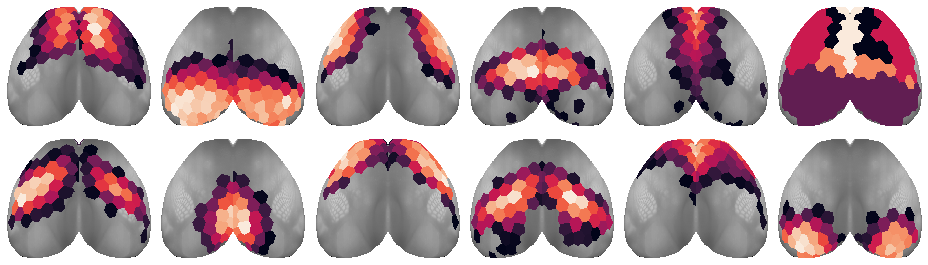

In [38]:
quick_show(tr, gr_ca.trim2d(proj_ca), .15)

In [54]:
props_ca['num_k'] = 6
gr_ca = Group(**props_ca).fit_group()
tr_ca = gr_ca.project_vec(gr_ca.grp_pi)
tr_ca = gr_ca.trim2d(tr_ca)

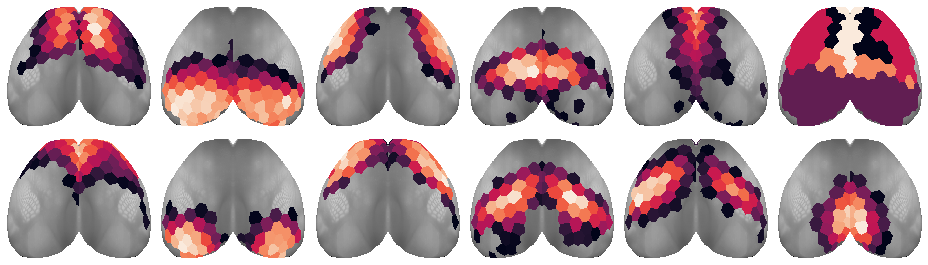

In [55]:
quick_show(tr, tr_ca, .15)

In [56]:
sim = dist2sim(sp_dist.cdist(pi, gr_ca.grp_pi, 'correlation'))
ids = list(find_best_match(sim).values())
ids

[4, 1, 2, 3, 0]

In [57]:
ids = ids + [5]

In [58]:
gr_ca.pi = gr_ca.grp_pi[ids]
tr_ca = gr_ca.project_vec()
tr_ca = gr_ca.trim2d(tr_ca)

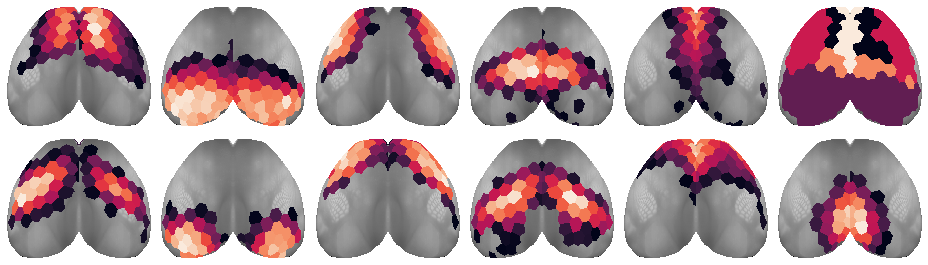

In [59]:
quick_show(tr, tr_ca, .15)

In [60]:
sim = dist2sim(sp_dist.cdist(pi, gr_ca.pi, 'correlation'))

<AxesSubplot:>

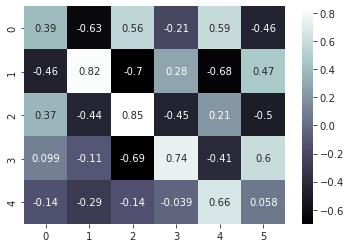

In [61]:
sns.heatmap(sim, cmap='bone', square=True, annot=True)

[4, 1, 2, 3, 0]

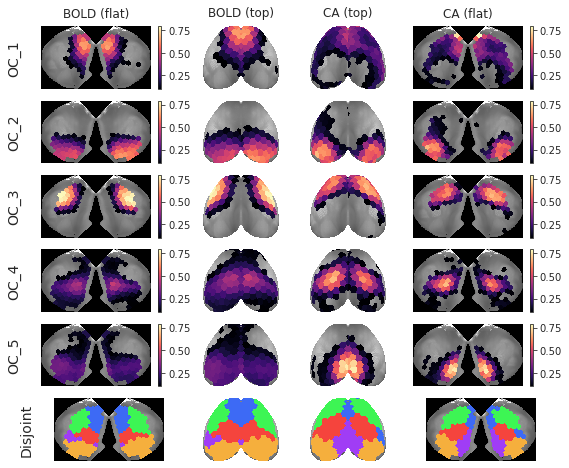

In [5]:
_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.10,
)

------------------------------    n_top = 000    ------------------------------

BOLD (corr)   : : :   ovp: 0.9718,  disj: 0.9533

Ca2  (corr)   : : :   ovp: 0.9774,  disj: 0.9429

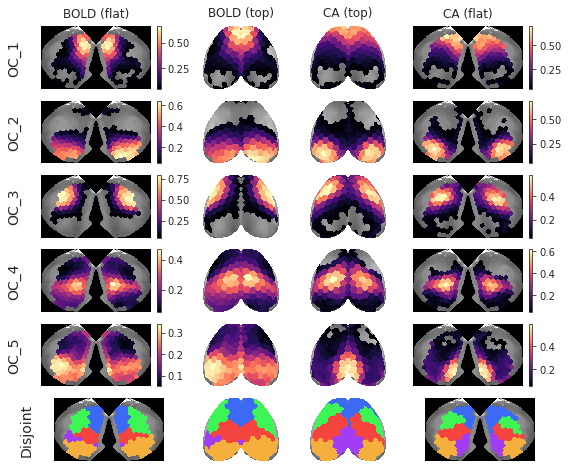

Similarity between OCs (correlation):  Avg = 0.805
OC1: 0.77, OC2: 0.88, OC3: 0.91, OC4: 0.88, OC5: 0.59,

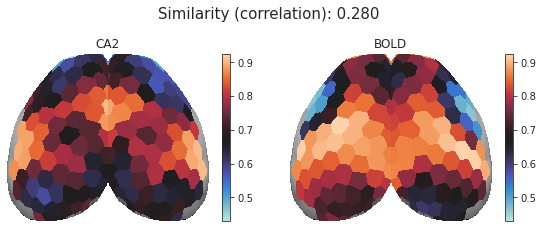

-------------------------------------------------------------------------------

------------------------------    n_top = 001    ------------------------------

BOLD (corr)   : : :   ovp: 0.9142,  disj: 0.8546

Ca2  (corr)   : : :   ovp: 0.9607,  disj: 0.9688

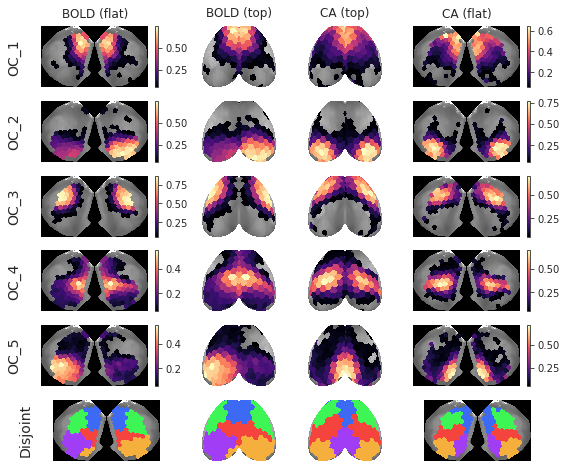

Similarity between OCs (correlation):  Avg = 0.684
OC1: 0.88, OC2: 0.79, OC3: 0.84, OC4: 0.59, OC5: 0.32,

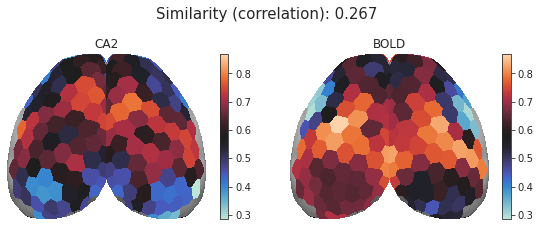

-------------------------------------------------------------------------------

------------------------------    n_top = 100    ------------------------------

BOLD (corr)   : : :   ovp: 0.8769,  disj: 0.8390

Ca2  (corr)   : : :   ovp: 0.9725,  disj: 0.9636

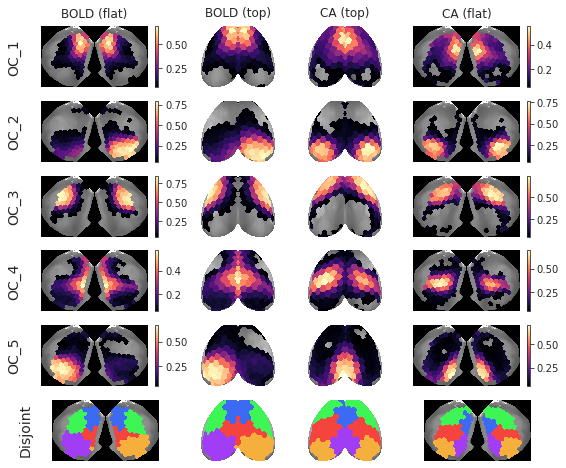

Similarity between OCs (correlation):  Avg = 0.586
OC1: 0.84, OC2: 0.71, OC3: 0.76, OC4: 0.34, OC5: 0.28,

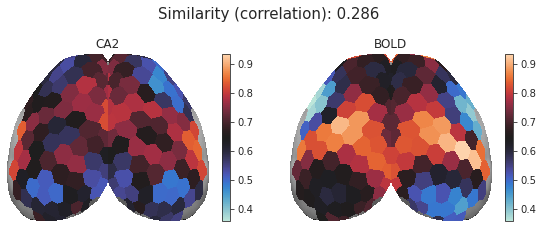

-------------------------------------------------------------------------------

------------------------------    n_top = 200    ------------------------------

BOLD (corr)   : : :   ovp: 0.8704,  disj: 0.8286

Ca2  (corr)   : : :   ovp: 0.9695,  disj: 0.9584

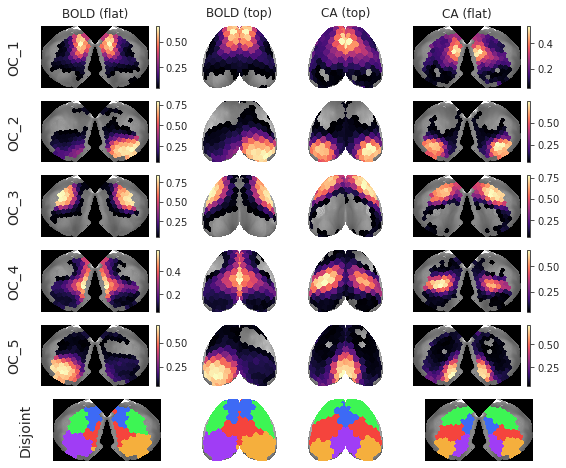

Similarity between OCs (correlation):  Avg = 0.556
OC1: 0.78, OC2: 0.70, OC3: 0.74, OC4: 0.26, OC5: 0.30,

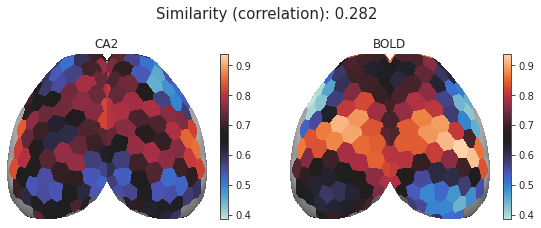

-------------------------------------------------------------------------------

------------------------------    n_top = 300    ------------------------------

BOLD (corr)   : : :   ovp: 0.8696,  disj: 0.8338

Ca2  (corr)   : : :   ovp: 0.9674,  disj: 0.9533

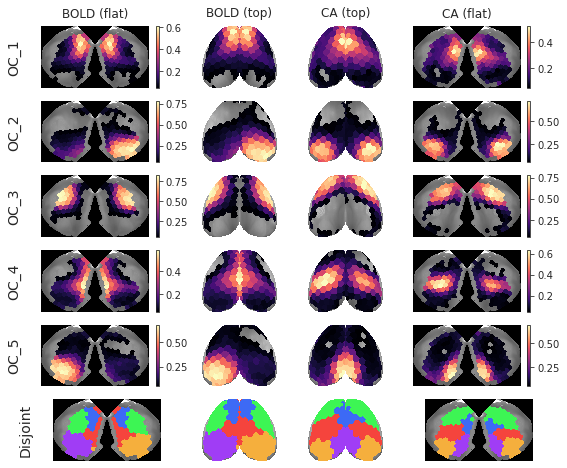

Similarity between OCs (correlation):  Avg = 0.538
OC1: 0.75, OC2: 0.69, OC3: 0.73, OC4: 0.20, OC5: 0.31,

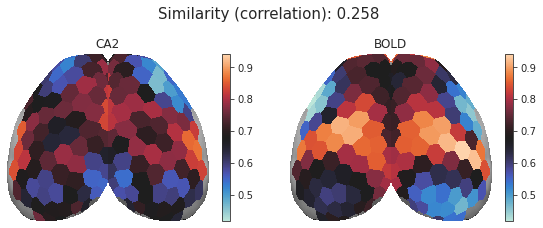

-------------------------------------------------------------------------------

CPU times: user 39min 11s, sys: 4min 17s, total: 43min 29s
Wall time: 30min 9s


In [4]:
%%time

for n_top in [0, 1, 100, 200, 300]:
    print('-' * 30, f'   n_top = {n_top:03d}   ', '-' * 30)
    
    gr_ca = Group(**props_ca).fit_group(force=True, n_top=n_top)
    gr_bo = Group(**props_bo).fit_group(force=True, n_top=n_top)
    gr_ca = Group(**props_ca).fit_group()
    gr_bo = Group(**props_bo).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=gr_bo.grp_pi,
        XB=gr_ca.grp_pi,
        metric='correlation',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    gr_bo.pi = gr_bo.grp_pi
    gr_ca.pi = gr_ca.grp_pi[ids]
    
    proj_bo = gr_bo.project_vec()
    proj_ca = gr_ca.project_vec()
    
    h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
    proj = gr_ca.project_vec(h, add_disjoint=False)
    tr = gr_ca.trim2d(proj)

    ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
    ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

    _ = gr_ca.show(
        proj_1=proj_bo,
        proj_2=proj_ca,
        cmaps=('magma',) * 2,
        labels=('BOLD', 'CA'),
        fix_cmap=False,
        min_thres=0.05,
    )
    score = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
    msg = f'Similarity between OCs (correlation):  Avg = {score.mean():0.3f}\n'
    for i in range(num_k):
        msg += f'OC{i+1}: {score[i]:0.2f}, '
    msg += '\n'
    print(msg)
    
    vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
    vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
    kwargs = {'cmap': 'icefire', 'vmin': vmin, 'vmax': vmax}

    fig, axes = create_figure(1, 2, (8, 3))
    for ax in axes.flat:
        ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
    im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), **kwargs)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title('CA2')
    im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), **kwargs)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title('BOLD')
    sim_h = sp_stats.pearsonr(gr_ca.grp_h, gr_bo.grp_h)[0]
    fig.suptitle(f'Similarity (correlation): {sim_h:0.3f}', y=1.04, fontsize=15)
    remove_ticks(axes)
    plt.show()
    
    print('-' * 79)
    print('\n\n')

In [9]:
props_ca['perc'] = 'p25-sample'
props_bo['perc'] = 'p25-sample'

------------------------------    n_top = 000    ------------------------------

BOLD (corr)   : : :   ovp: 0.9763,  disj: 0.9480

Ca2  (corr)   : : :   ovp: 0.9776,  disj: 0.9688

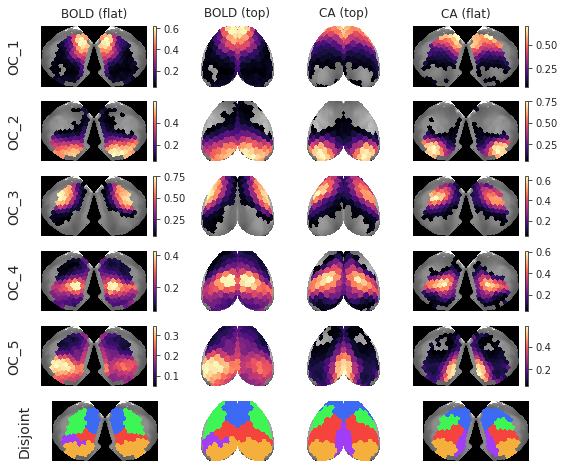

Similarity between OCs (correlation):  Avg = 0.762
OC1: 0.79, OC2: 0.87, OC3: 0.93, OC4: 0.83, OC5: 0.39,

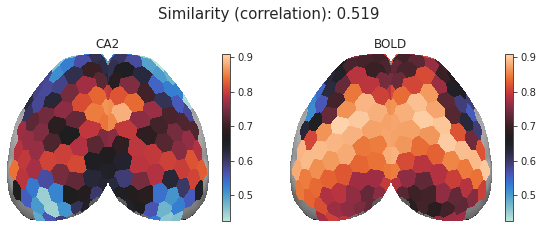

-------------------------------------------------------------------------------

------------------------------    n_top = 001    ------------------------------

BOLD (corr)   : : :   ovp: 0.9279,  disj: 0.8961

Ca2  (corr)   : : :   ovp: 0.9768,  disj: 0.9533

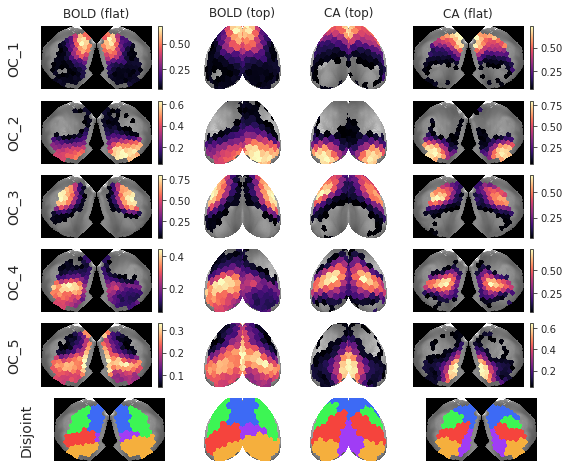

Similarity between OCs (correlation):  Avg = 0.704
OC1: 0.79, OC2: 0.80, OC3: 0.91, OC4: 0.49, OC5: 0.53,

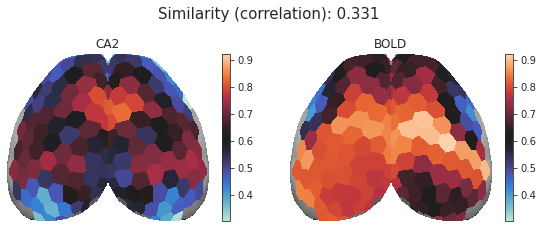

-------------------------------------------------------------------------------

------------------------------    n_top = 100    ------------------------------

BOLD (corr)   : : :   ovp: 0.8807,  disj: 0.8338

Ca2  (corr)   : : :   ovp: 0.9842,  disj: 0.9740

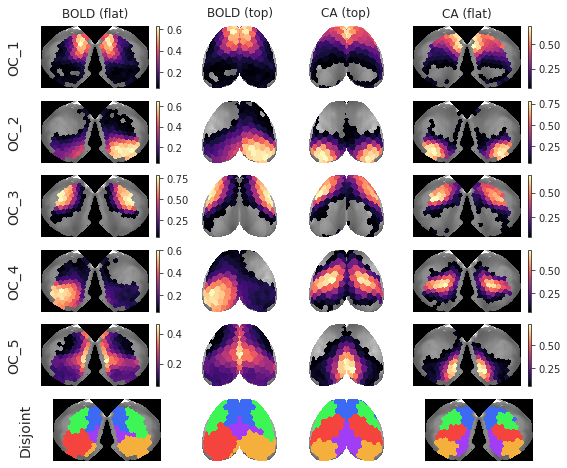

Similarity between OCs (correlation):  Avg = 0.607
OC1: 0.81, OC2: 0.67, OC3: 0.89, OC4: 0.19, OC5: 0.47,

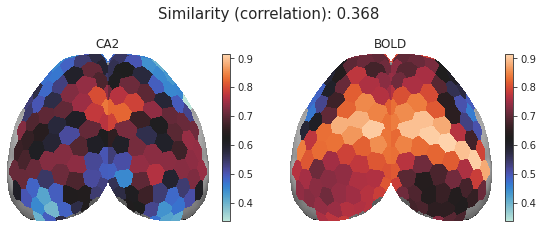

-------------------------------------------------------------------------------

------------------------------    n_top = 200    ------------------------------

BOLD (corr)   : : :   ovp: 0.8737,  disj: 0.8182

Ca2  (corr)   : : :   ovp: 0.9838,  disj: 0.9688

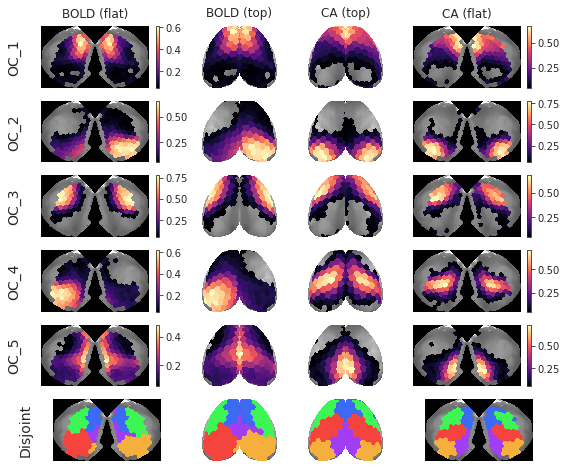

Similarity between OCs (correlation):  Avg = 0.591
OC1: 0.83, OC2: 0.65, OC3: 0.88, OC4: 0.14, OC5: 0.46,

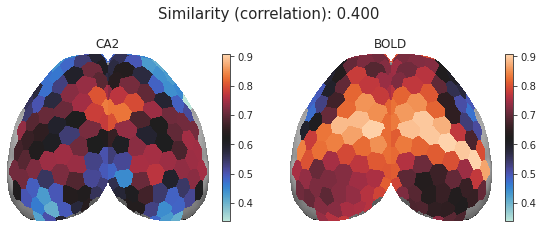

-------------------------------------------------------------------------------

CPU times: user 31min 19s, sys: 3min 25s, total: 34min 45s
Wall time: 25min 4s


In [10]:
%%time

for n_top in [0, 1, 100, 200]:
    print('-' * 30, f'   n_top = {n_top:03d}   ', '-' * 30)
    
    gr_ca = Group(**props_ca).fit_group(force=True, n_top=n_top)
    gr_bo = Group(**props_bo).fit_group(force=True, n_top=n_top)
    gr_ca = Group(**props_ca).fit_group()
    gr_bo = Group(**props_bo).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=gr_bo.grp_pi,
        XB=gr_ca.grp_pi,
        metric='correlation',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    gr_bo.pi = gr_bo.grp_pi
    gr_ca.pi = gr_ca.grp_pi[ids]
    
    proj_bo = gr_bo.project_vec()
    proj_ca = gr_ca.project_vec()
    
    h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
    proj = gr_ca.project_vec(h, add_disjoint=False)
    tr = gr_ca.trim2d(proj)

    ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
    ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

    _ = gr_ca.show(
        proj_1=proj_bo,
        proj_2=proj_ca,
        cmaps=('magma',) * 2,
        labels=('BOLD', 'CA'),
        fix_cmap=False,
        min_thres=0.05,
    )
    score = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
    msg = f'Similarity between OCs (correlation):  Avg = {score.mean():0.3f}\n'
    for i in range(num_k):
        msg += f'OC{i+1}: {score[i]:0.2f}, '
    msg += '\n'
    print(msg)
    
    vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
    vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
    kwargs = {'cmap': 'icefire', 'vmin': vmin, 'vmax': vmax}

    fig, axes = create_figure(1, 2, (8, 3))
    for ax in axes.flat:
        ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
    im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), **kwargs)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title('CA2')
    im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), **kwargs)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title('BOLD')
    sim_h = sp_stats.pearsonr(gr_ca.grp_h, gr_bo.grp_h)[0]
    fig.suptitle(f'Similarity (correlation): {sim_h:0.3f}', y=1.04, fontsize=15)
    remove_ticks(axes)
    plt.show()
    
    print('-' * 79)
    print('\n\n')

In [4]:
gr_ca = Group(**props_ca).fit_group(force=True, n_top=0)
gr_bo = Group(**props_bo).fit_group(force=True, n_top=0)

[PROGRESS] 'se_indiv-pi_1.0e+02.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/results/SVINET/Gro
up/real_pearson_ca2_k5_p25-sample

[PROGRESS] 'se_indiv-pi_1.0e+02.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/results/SVINET/Gro
up/real_pearson_bold-lite_k5_p25-sample

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bo.grp_pi,
    XB=gr_ca.grp_pi,
    metric='correlation',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bo.pi = gr_bo.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

ids

[0, 1, 2, 3, 4]

BOLD (cos)   : : :   ovp: 0.9931,  disj: 0.9533

Ca2  (cos)   : : :   ovp: 0.9900,  disj: 0.9429

BOLD (corr)   : : :   ovp: 0.9718,  disj: 0.9533

Ca2  (corr)   : : :   ovp: 0.9774,  disj: 0.9429

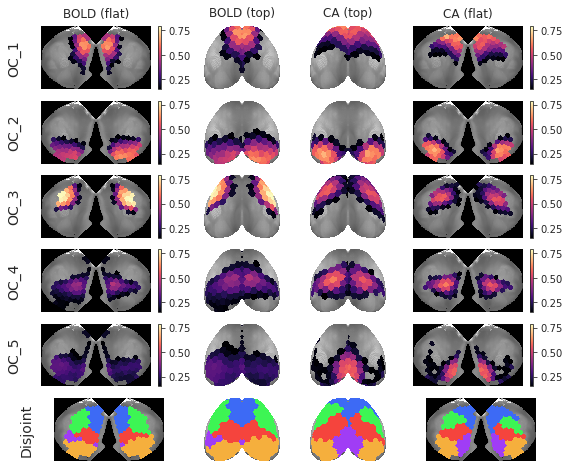

In [7]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='cosine')
print(f"BOLD (cos)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='cosine')
print(f"Ca2  (cos)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    min_thres=0.15,
)

In [8]:
sim = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
sim.mean(), sim

(
    0.8045905642503733,
    array([0.77256247, 0.87611373, 0.90864038, 0.8775671 , 0.58806914])
)

In [14]:
sim = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
sim.mean(), sim

(
    0.7619878878106711,
    array([0.79168126, 0.86979172, 0.92683994, 0.83400457, 0.38762197])
)

BOLD   : : :   ovp: 0.9931,  disj: 0.9533

Ca2    : : :   ovp: 0.9900,  disj: 0.9429

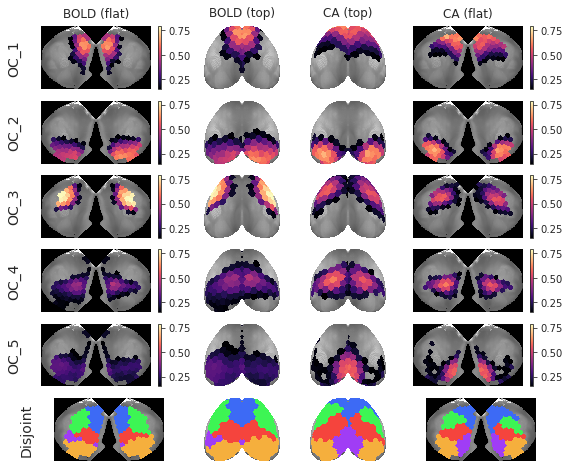

array([0.89759295, 0.93812407, 0.93647299, 0.93802766, 0.86423032])

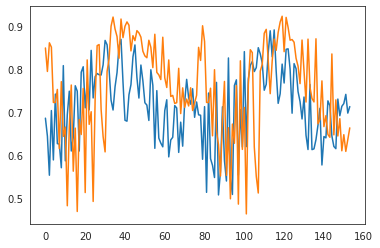

In [22]:
h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
plt.plot(h[0])
plt.plot(h[1]);

In [23]:
proj = gr_ca.project_vec(h, add_disjoint=False)
tr = gr_ca.trim2d(proj)

In [24]:
vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
vmin, vmax

(0.46224414488975507, 0.9232122642849067)

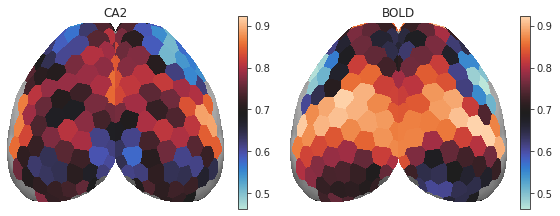

In [25]:
cmap = 'icefire'

fig, axes = create_figure(1, 2, (8, 3))
for ax in axes.flat:
    ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[0])
axes[0].set_title('CA2')
im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axes[1])
axes[1].set_title('BOLD')

remove_ticks(axes)
plt.show()

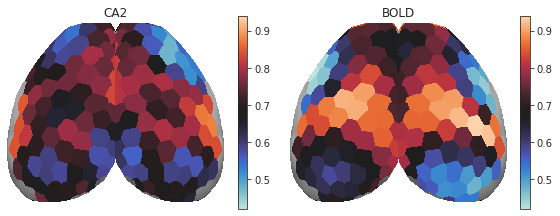

In [26]:
np.nanmax(gr_bo.run_h)

1.1600678099495998

In [14]:
np.where(gr_bo.run_h == np.nanmax(gr_bo.run_h))

(array([3, 3]), array([0, 0]), array([2, 2]), array([46, 47]))

In [15]:
gr_bo.run_h[3, 0, 2]

memmap([0.71320275, 0.69312953, 1.09754894, 0.64126607, 0.87871521,
        0.485734  , 0.55498702, 0.65078985, 0.62387195, 0.63271541,
        0.8798883 , 0.80231723, 0.47001186, 0.5968465 , 0.6866903 ,
        0.58634956, 0.67959686, 0.70769929, 0.60257661, 0.81507713,
        0.61179007, 0.77589851, 0.70691357, 0.629091  , 0.59238888,
        0.65745126, 0.91709804, 0.81379251, 0.59836769, 0.5756306 ,
        0.56720258, 0.69030796, 0.60020893, 0.78689179, 0.70958667,
        0.55644272, 0.53600768, 0.63205321, 0.54688092,        nan,
        0.99586822, 0.69267119, 0.56236773, 0.7130031 , 0.53732076,
        0.54922194, 1.16028802, 1.16028802, 1.00435786, 0.56403627,
        0.53606003, 0.58192178, 0.46127951, 1.01175578, 0.57775628,
        0.57526951, 0.56798097, 0.61422719, 0.69720302, 0.55481447,
        0.58019522, 0.83379799, 1.05131615, 0.70747793, 0.74026226,
        0.59064957, 0.62390361, 0.52537374, 0.96287323, 0.68118029,
        0.85907195, 0.78626667, 0.86639006, 0.65961604, 0.72023512,
        0.69212539, 0.6880553 , 0.6604456 , 0.58225972, 0.9546752 ,
        0.61798952, 0.62352893, 0.38667467, 0.65013914,        nan,
        0.94534586, 0.58215547, 0.72410356, 0.8610189 , 0.5071053 ,
        0.69736315, 0.66449118, 0.61196331, 0.60364488, 0.56705562,
        0.60285937, 0.59493677, 0.663222  , 0.72222596, 0.70371705,
        0.63285346, 0.59086805, 0.66440086, 0.72852126, 0.73233486,
        0.69094584, 0.56750941, 0.56053122, 0.66209945, 0.71710452,
        0.83113222, 0.78990438, 0.6281358 , 0.61732922, 0.65788915,
        0.70445682, 1.00214772, 0.9687276 , 0.70330976, 0.67128062,
        0.49446425, 0.70580024, 0.80310595, 1.06187256, 1.14889813,
        0.69782734, 0.741683  , 0.38950811, 0.58113627, 0.4894412 ,
        0.22152928, 0.19939259, 0.7628918 , 0.1277853 , 0.12829611,
        0.15756138, 0.42615582, 0.17941369, 0.14015762, 0.36625414,
        0.12547698, 0.12620923, 0.14245315, 0.12990778, 0.8821978 ,
        0.23626053, 0.79320708, 0.29013171, 0.20560188, 0.18694904,
        0.12440494, 0.33178769, 0.72341648, 0.4541855 ])

In [18]:
a = gr_bo.run_pi_prune[3, 0, 2]
a.shape

(5, 154)

In [20]:
a[:, 46:49]

memmap([[0.        , 0.25798788, 0.        ],
        [0.        , 0.23775546, 0.        ],
        [0.        , 0.        , 0.        ],
        [0.50421348, 0.25425301, 0.22089012],
        [0.49578652, 0.25000365, 0.77910988]])

In [21]:
b = sp_stats.entropy(gr_bo.run_pi[8, 2, 1], axis=0) / np.log(5)

<AxesSubplot:ylabel='Count'>

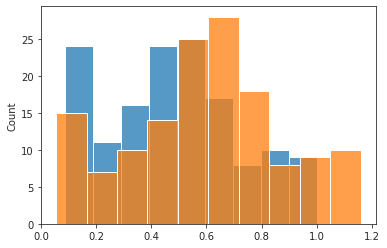

In [23]:
sns.histplot(b)
sns.histplot(gr_bo.run_h[8, 2, 1], color='C1')